In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('creditcard.csv')
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [3]:
df.shape

(284807, 31)

In [4]:
# Toutes les variables sont mises à l'échelle hormis les variables Amount et Time. Nous les traitons à l'aide
# RobustScaler qui est moins sensible aux outliers que StandardScaler
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [5]:
#seuls 0.17% des transactions sont frauduleuses. 
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [6]:
#aucune donnée n'est manquante
df.isnull().sum().max()

0

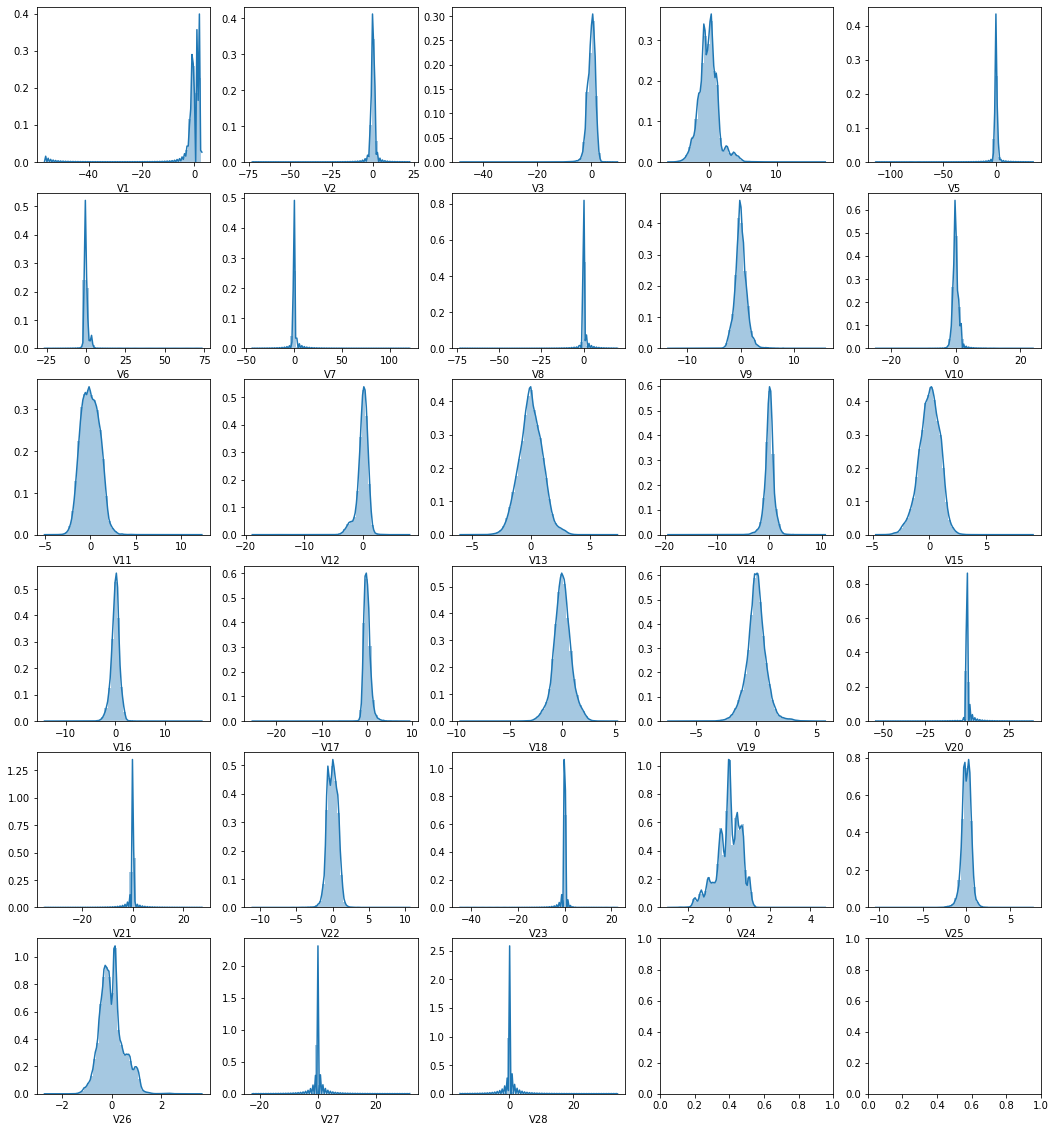

In [7]:
#les variables suivent à peu près la loi normale. Nous ne leur appliquerons aucune transformation pour l'instant:
fig, axes = plt.subplots(ncols=5, nrows=6,figsize=(18,20))
columns = ['V1','V2','V3','V4','V5','V6','V7','V8','V9', 
           'V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28']
for i, ax in zip(columns, axes.flat):
    sns.distplot(df[i], ax=ax)
plt.show()

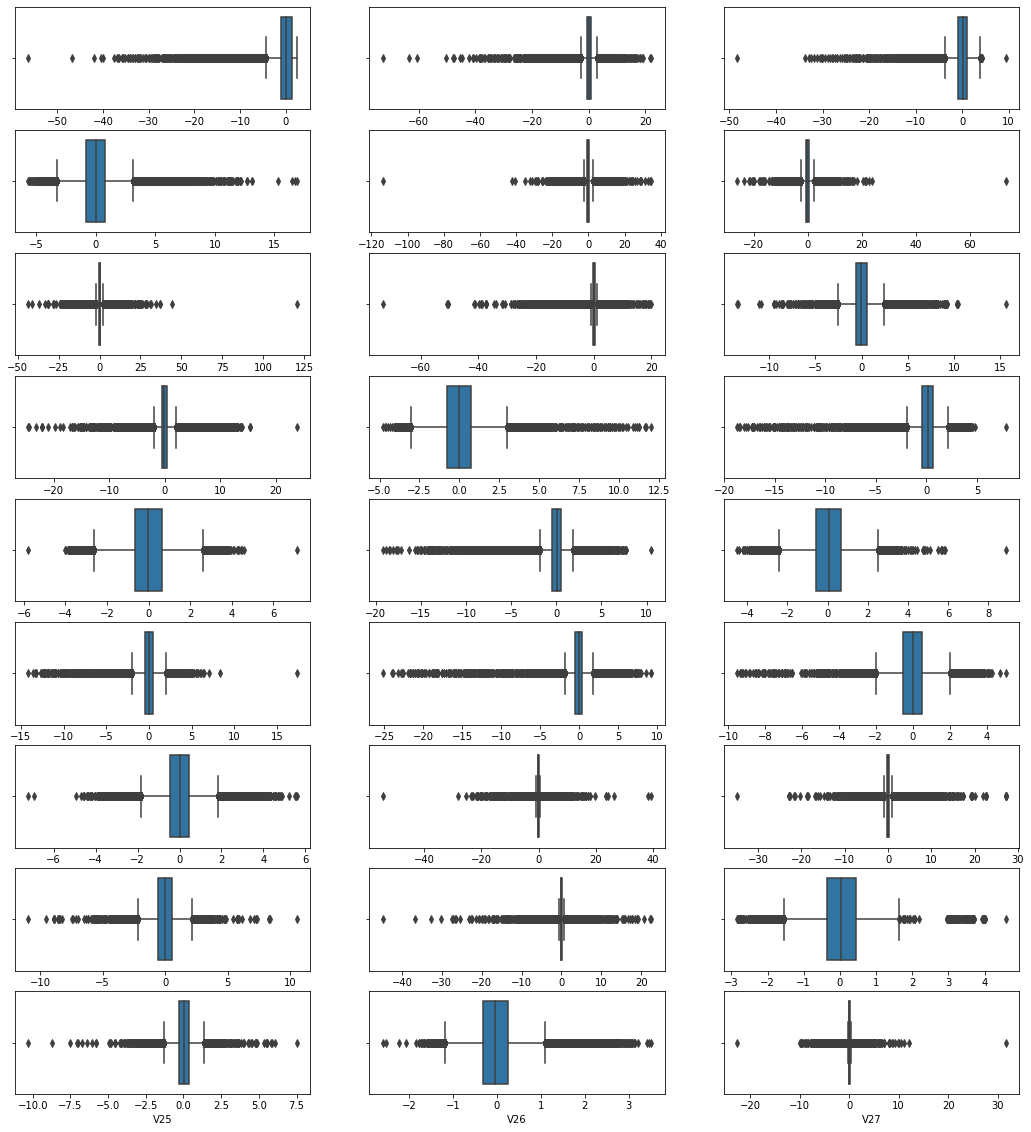

In [8]:
#Nous visualisons également les outliers à l'aide des boxplots:
fig, axes = plt.subplots(ncols=3, nrows=9,figsize=(18,20))
columns = ['V1','V2','V3','V4','V5','V6','V7','V8','V9', 
           'V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28']
for i, ax in zip(columns, axes.flat):
    sns.boxplot(df[i], ax=ax)
plt.show()

In [9]:
#Pourcentage d'outliers pour chacune des variables:

columns = ['V1','V2','V3','V4','V5','V6','V7','V8','V9', 
           'V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28']
for i in columns:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    print("Pourcentage d'outliers dans",i ,"est de", (len(df[((df[i] < (Q1 - 1.5 * IQR)) | (df[i] > (Q3 + 1.5 * IQR)))].index))/len(df[i])*100,"%")

Pourcentage d'outliers dans V1 est de 2.4795738868777804 %
Pourcentage d'outliers dans V2 est de 4.7491810243428 %
Pourcentage d'outliers dans V3 est de 1.1807996292225964 %
Pourcentage d'outliers dans V4 est de 3.9142296362097846 %
Pourcentage d'outliers dans V5 est de 4.316958501722219 %
Pourcentage d'outliers dans V6 est de 8.063355184388024 %
Pourcentage d'outliers dans V7 est de 3.1417767119487934 %
Pourcentage d'outliers dans V8 est de 8.47380857914307 %
Pourcentage d'outliers dans V9 est de 2.9082852598426303 %
Pourcentage d'outliers dans V10 est de 3.334187713082895 %
Pourcentage d'outliers dans V11 est de 0.27386967314707855 %
Pourcentage d'outliers dans V12 est de 5.3889124916171305 %
Pourcentage d'outliers dans V13 est de 1.182555204050462 %
Pourcentage d'outliers dans V14 est de 4.96792564789489 %
Pourcentage d'outliers dans V15 est de 1.0161267103687759 %
Pourcentage d'outliers dans V16 est de 2.873524878250886 %
Pourcentage d'outliers dans V17 est de 2.605273044552978 %
P

Text(0.5, 1, 'correlation heatmap')

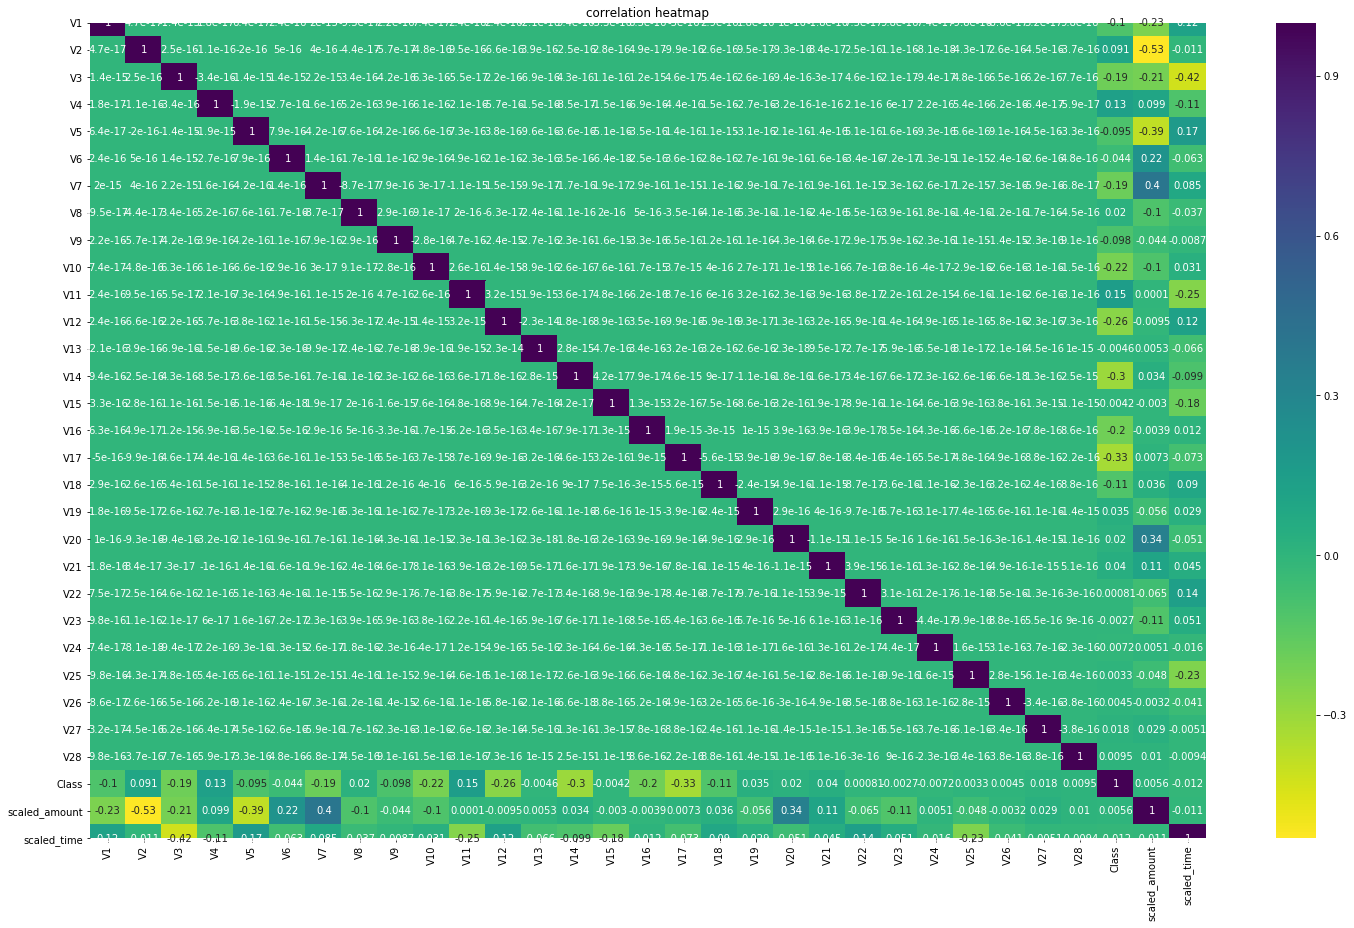

In [10]:
#les variables les plus corrélées à la variable réponse sont: V17, V14 et V12
plt.figure(figsize=(25,15))
sns.heatmap(df.corr(), annot=True, cmap='viridis_r');
plt.title('correlation heatmap')

In [11]:
#V17 est la variable la plus corrélée à la variable cible. Pour éviter le surapprentissage et étant donné que notre dataset est déséquilibré avec très peu de transactions frauduleuses,
#nous effectuerons un échantillonnage sur les transactions non frauduleuses pour aboutir à un équilibre d'environ 50%/50%. 
#Nous nous servirons de la nouvelle variable V17_categorical pour réaliser un échantillonnage stratifié.
#Pour cela, on utilise un découpage par quantiles empiriques:
r = [df['V17'].quantile(0), df['V17'].quantile(0.25), df['V17'].quantile(0.5), df['V17'].quantile(0.75), df['V17'].quantile(1)]
g = [1,2,3,4]
df['V17_categorical'] = pd.cut(df['V17'], bins=r, labels=g, include_lowest=True)

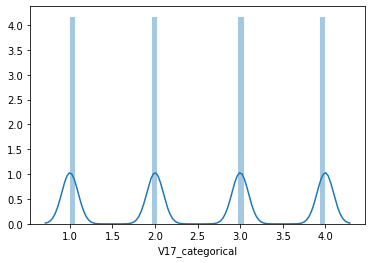

In [12]:
#On va faire de l'échantillonnage stratifié du dataframe en fonction de la variable V17_categorcial
import seaborn as sns
sns.distplot(df.V17_categorical)
plt.show()

In [13]:
df['V17_categorical'].value_counts().sort_index()

1    71202
2    71202
3    71201
4    71202
Name: V17_categorical, dtype: int64

In [14]:
#Pour cela, nous utilisons la fonction StratifiedShuffleSplit afin d'équilibrer les classes 0 et 1. 
#Une autre solution et qui serait plus pertinente serait de procéder à l'oversampling à l'aide de la méthode 
#SMOTE permettant de faire du suréchantillonnage avec remplacement plutôt que d'utiliser les méthodes aléatoires.
#D'autres méthodes d'undersampling sont également possibles.
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(test_size=len(df[df['Class']==1]) / len(df[df['Class']==0]))

for df_index, test_index in split.split(df, df['V17_categorical']):
    strat_df = df.loc[df_index]
    strat_test_df = df.loc[test_index]                        

In [15]:
#On voit que l'échantillonnage réalisé maintient une bonne répartition des données 
strat_test_df['V17_categorical'].value_counts().sort_index()

1    124
2    123
3    123
4    123
Name: V17_categorical, dtype: int64

In [16]:
#Nous créons un nouveau dataframe résultat de la concaténation du dataframe stratifié est du dataframe original (pour
#les transactions frauduleuses)
new_df = pd.concat([strat_test_df, df[df['Class']==1]])

In [17]:
new_df['Class'].value_counts()

1    495
0    490
Name: Class, dtype: int64

In [18]:
new_df = new_df.drop('V17_categorical', axis=1)

Text(0.5, 1, 'correlation heatmap')

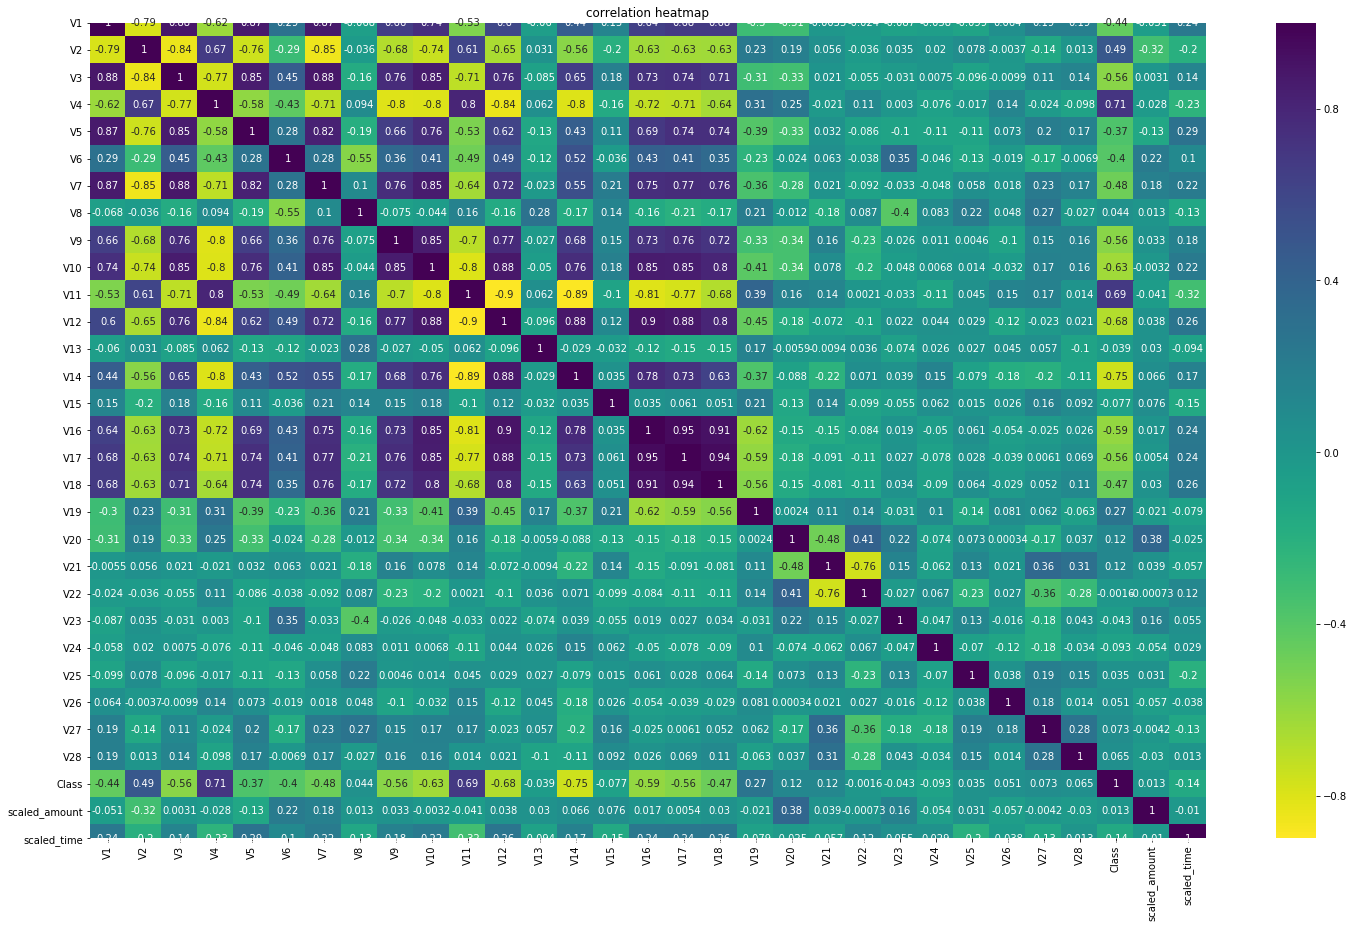

In [19]:
#les variables les plus corrélées à la variable réponse sont: V17, V14 et V12
plt.figure(figsize=(25,15))
sns.heatmap(new_df.corr(), annot=True, cmap='viridis_r');
plt.title('correlation heatmap')

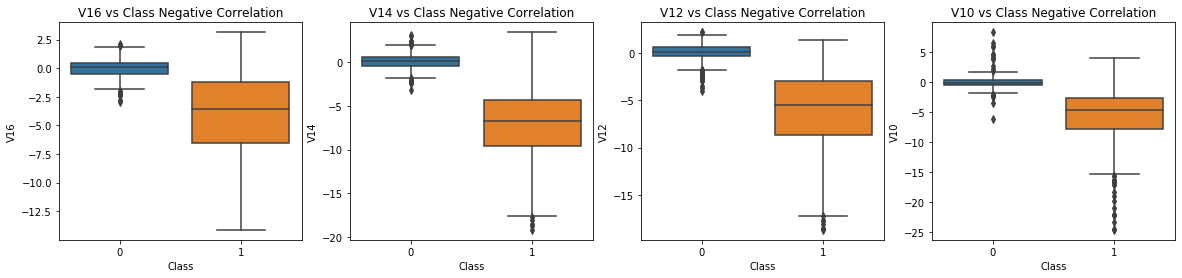

In [20]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

#Nous visualisons les plus fortes corrélations négatives avec la cible. Plus les valeurs sont faibles pour la classe 1,
#plus il y'a de chance qu'elles correspondent à des transactions frauduleuses:
sns.boxplot(x="Class", y="V16", data=new_df, ax=axes[0])
axes[0].set_title('V16 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

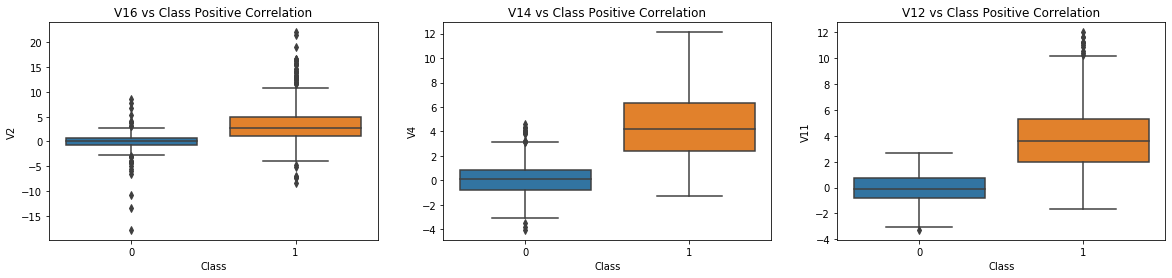

In [21]:
f, axes = plt.subplots(ncols=3, figsize=(20,4))

#A l'inverse, nous visualisons ici les plus fortes corrélations positives avec la cible: 
sns.boxplot(x="Class", y="V2", data=new_df, ax=axes[0])
axes[0].set_title('V16 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, ax=axes[1])
axes[1].set_title('V14 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V11", data=new_df, ax=axes[2])
axes[2].set_title('V12 vs Class Positive Correlation')


plt.show()

In [22]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [23]:
# Nous implémentons la méthode T-SNE pour la visualisation: 
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

# Nous implémentons également l'ACP
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)

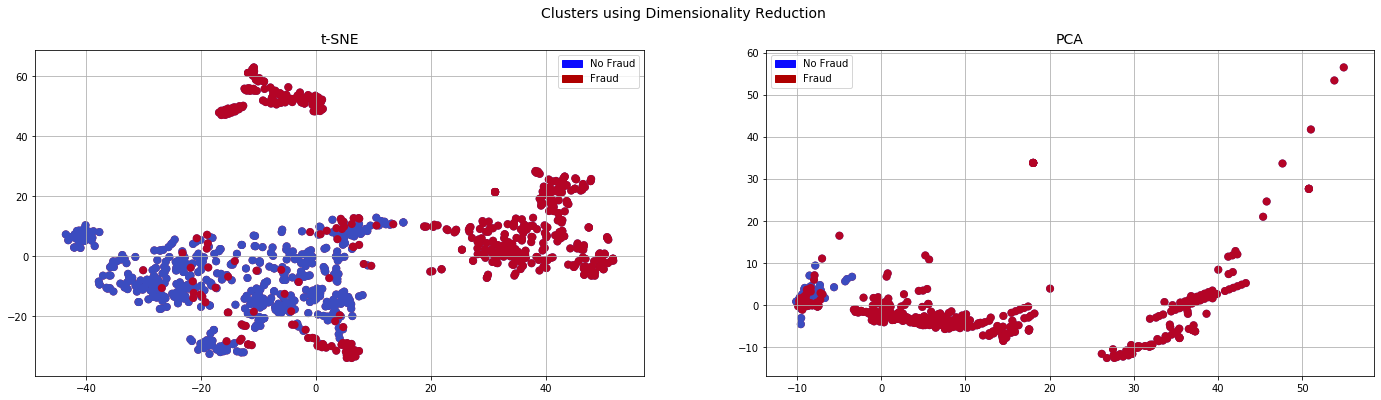

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])


plt.show()

In [25]:
# Nous séparons les données d'apprentissage et données tests (30% du dataset)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
# Nous passons les données sous forme d'arrays pour alimenter le modèle
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [27]:
#Ici nous testons 4 algorithmes de classification et en retiendrons un seul

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [28]:
#Logistic regression comme à l'attendu fournit de bonnes performances
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(classifier.__class__.__name__, "a un score d'apprentissage de", round(training_score.mean(), 2) * 100, "% accuracy score")

LogisticRegression a un score d'apprentissage de 94.0 % accuracy score
KNeighborsClassifier a un score d'apprentissage de 94.0 % accuracy score
SVC a un score d'apprentissage de 93.0 % accuracy score
DecisionTreeClassifier a un score d'apprentissage de 93.0 % accuracy score


In [29]:
# Nous utilisons GridSearch pour déterminer les meilleurs paramètres.
from sklearn.model_selection import GridSearchCV

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
#Nous obtenons le modèle de régression logistique avec les meilleurs paramètres:
log_reg = grid_log_reg.best_estimator_

In [30]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Nous créons un dataframe avec tous les scores et classifiers

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

In [31]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))

Logistic Regression:  0.9772543401314681


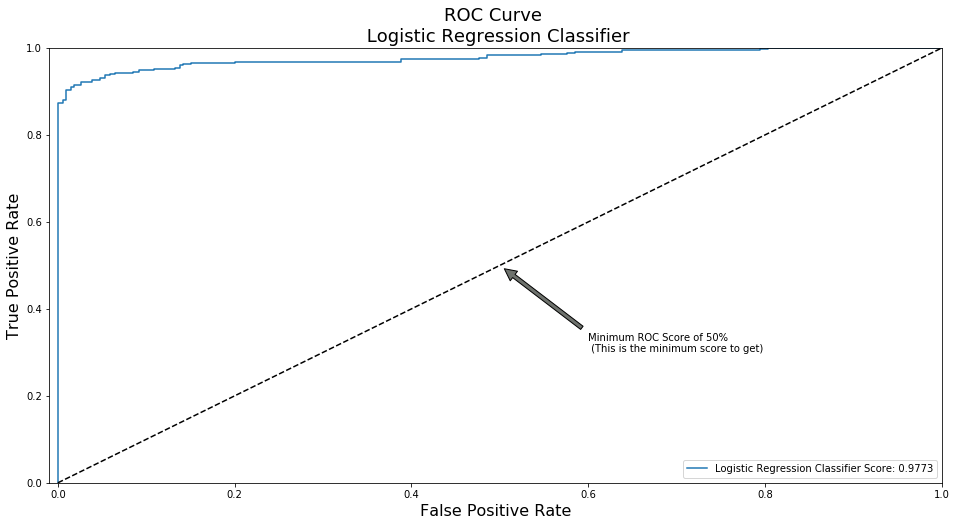

In [32]:
#Nous visualisons la courbe ROC qui mesure les performances du modèle. Nous retiendrons ici la régression logistique
#à appliquer sur nos données
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)

def graph_roc_curve_multiple(log_fpr, log_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Logistic Regression Classifier', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr)
plt.show()

In [33]:
log_reg.fit(X_train,y_train)
y_pred=log_reg.predict(X_test)

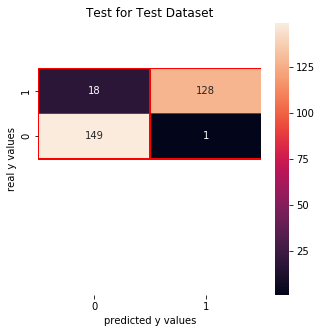

In [34]:
#Matrice de confusion. Ici le plus important est de détecter le maximum d'opérations frauduleuses:
#le but est de trouver le modèle qui minimise les false negatives sur les transactions frauduleuses.
from sklearn.metrics import confusion_matrix 

cm=confusion_matrix(y_test,y_pred)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.title("Test for Test Dataset")
plt.xlabel("predicted y values")
plt.ylabel("real y values")
plt.ylim([-3, 3])
plt.show()

In [35]:
#Nous séparons les variables discriminantes de la variable cible pour le dataset initial:
original_X = df.drop('Class', axis=1)
original_y = df['Class']

In [36]:
#Nous appliquons le modèle au dataset initial:
log_reg.fit(original_X,original_y)
y_pred=log_reg.predict(original_X)

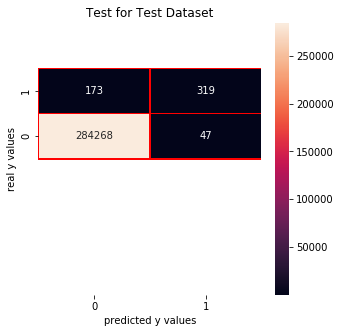

In [37]:
#172/492 (34.9%) transactions frauduleuses sont mal classifiées par le modèle. Ce ratio peut être amélioré.
from sklearn.metrics import confusion_matrix 

cm=confusion_matrix(original_y,y_pred)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.title("Test for Test Dataset")
plt.xlabel("predicted y values")
plt.ylabel("real y values")
plt.ylim([-3, 3])
plt.show()

In [38]:
#Ici nous allons évaluer les performances de la régression logistique appliquée directement aux données initiales 
#après découpage (train, test) afin d'évaluer l'apport du sous-échantillonnage réalisé précédemment:
X = df.drop('Class', axis=1)
y = df['Class']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
clf = LogisticRegression()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

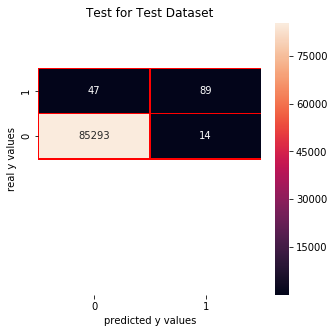

In [41]:
#52.8% des transactions frauduleuses sont mal classifiées par le modèle. L'over-sampling nous a donc permis d'améliorer
#grandement notre modèle, même si les résultats peuvent encore être améliorés notamment la minimisation des
#false negatives
from sklearn.metrics import confusion_matrix 

cm=confusion_matrix(y_test,y_pred)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.title("Test for Test Dataset")
plt.xlabel("predicted y values")
plt.ylabel("real y values")
plt.ylim([-3, 3])
plt.show()